In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
input_folder = "/content/drive/My Drive/InputData"
print(os.listdir(input_folder))

['GrayLeafSpot', 'HealthyLeaf']


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
input_folder = "/content/drive/My Drive/InputData"
output_folder = "/content/drive/My Drive/OrganizedData"

# Classes (subfolders in InputData)
classes = ["GrayLeafSpot", "HealthyLeaf"]

# Train, Validation, Test split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Create output folders
for split in ["train", "val", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(output_folder, split, cls), exist_ok=True)

# Split the dataset
for cls in classes:
    class_folder = os.path.join(input_folder, cls)
    images = [f for f in os.listdir(class_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Class: {cls}, Total images: {len(images)}")

    # Skip splitting if there are not enough images
    if len(images) < 3:  # Minimum 3 images needed for train/val/test split
        print(f"Not enough images in class '{cls}' to split. Copying all to train...")
        for image in images:
            shutil.copy(os.path.join(class_folder, image), os.path.join(output_folder, "train", cls, image))
        continue

    # Perform train/val/test split
    train_images, temp_images = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

    # Copy files to respective directories
    for image in train_images:
        shutil.copy(os.path.join(class_folder, image), os.path.join(output_folder, "train", cls, image))
    for image in val_images:
        shutil.copy(os.path.join(class_folder, image), os.path.join(output_folder, "val", cls, image))
    for image in test_images:
        shutil.copy(os.path.join(class_folder, image), os.path.join(output_folder, "test", cls, image))

print("Dataset organized into train, val, and test folders!")

Class: GrayLeafSpot, Total images: 999


KeyboardInterrupt: 

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Paths
train_dir = "/content/drive/My Drive/OrganizedData/train"
val_dir = "/content/drive/My Drive/OrganizedData/val"
test_dir = "/content/drive/My Drive/OrganizedData/test"

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data transformations
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Using device: cpu


In [ ]:
# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load pre-trained ResNet model
model = models.resnet50(pretrained=True)

# Replace the final layer to match the number of classes
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import os

print("Checking directory structure...")
print(f"Train directory: {train_dir}")
print(f"Contents of train directory: {os.listdir(train_dir)}")
print(f"Validation directory: {val_dir}")
print(f"Contents of validation directory: {os.listdir(val_dir)}")
print(f"Test directory: {test_dir}")
print(f"Contents of test directory: {os.listdir(test_dir)}")

Checking directory structure...
Train directory: /content/drive/My Drive/OrganizedData/train
Contents of train directory: ['GrayLeafSpot', 'HealthyLeaf']
Validation directory: /content/drive/My Drive/OrganizedData/val
Contents of validation directory: ['GrayLeafSpot', 'HealthyLeaf']
Test directory: /content/drive/My Drive/OrganizedData/test
Contents of test directory: ['GrayLeafSpot', 'HealthyLeaf']


In [14]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    best_val_acc = 0.0  # Initialize best validation accuracy
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f"Training Loss: {epoch_loss:.4f}")

        # Validation phase
        model.eval()
        val_acc = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_acc += torch.sum(preds == labels.data)

        val_acc = val_acc.double() / len(val_loader.dataset)
        print(f"Validation Accuracy: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_resnet_model.pth")
            print("Model saved!")

    print(f"Best Validation Accuracy: {best_val_acc:.4f}")

    # Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

Epoch 1/10
Training Loss: 0.2392
Validation Accuracy: 0.9585
Model saved!
Epoch 2/10
Training Loss: 0.1328
Validation Accuracy: 0.9792
Model saved!
Epoch 3/10
Training Loss: 0.0856
Validation Accuracy: 1.0000
Model saved!
Epoch 4/10
Training Loss: 0.0950
Validation Accuracy: 0.9689
Epoch 5/10
Training Loss: 0.0905
Validation Accuracy: 0.9862
Epoch 6/10
Training Loss: 0.0671
Validation Accuracy: 0.9896
Epoch 7/10
Training Loss: 0.1469
Validation Accuracy: 0.9965
Epoch 8/10
Training Loss: 0.0951
Validation Accuracy: 1.0000
Epoch 9/10
Training Loss: 0.0651
Validation Accuracy: 1.0000
Epoch 10/10
Training Loss: 0.0519
Validation Accuracy: 0.9862
Best Validation Accuracy: 1.0000


In [15]:
# Testing function
def test_model(model, test_loader):
    model.load_state_dict(torch.load("best_resnet_model.pth"))
    model.eval()
    test_acc = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_acc += torch.sum(preds == labels.data)

    test_acc = test_acc.double() / len(test_loader.dataset)
    print(f"Test Accuracy: {test_acc:.4f}")

# Test the model
test_model(model, test_loader)

<ipython-input-15-b5d149c06de7>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_resnet_model.pth"))


Test Accuracy: 0.9896


In [16]:
import matplotlib.pyplot as plt

# Train the model and get history
history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')
plt.show()


Epoch 1/10
Training Loss: 0.1133
Validation Accuracy: 0.9931
Model saved!
Epoch 2/10
Training Loss: 0.1388
Validation Accuracy: 0.9931
Epoch 3/10
Training Loss: 0.0379
Validation Accuracy: 0.9896
Epoch 4/10
Training Loss: 0.0465
Validation Accuracy: 0.9965
Model saved!
Epoch 5/10
Training Loss: 0.0380
Validation Accuracy: 1.0000
Model saved!
Epoch 6/10
Training Loss: 0.1536
Validation Accuracy: 0.9758
Epoch 7/10
Training Loss: 0.1634
Validation Accuracy: 0.9965
Epoch 8/10
Training Loss: 0.1788
Validation Accuracy: 0.9446
Epoch 9/10
Training Loss: 0.1146
Validation Accuracy: 0.9931
Epoch 10/10
Training Loss: 0.0673
Validation Accuracy: 1.0000
Best Validation Accuracy: 1.0000


TypeError: 'NoneType' object is not subscriptable

<Figure size 1000x500 with 0 Axes>

In [18]:
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


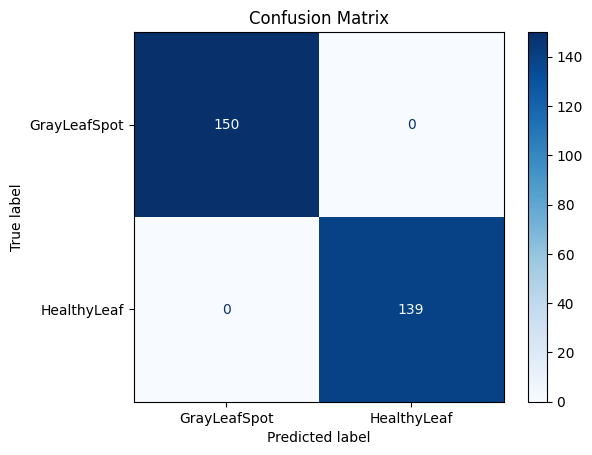

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [20]:
from sklearn.metrics import classification_report

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))



Classification Report:
              precision    recall  f1-score   support

GrayLeafSpot       1.00      1.00      1.00       150
 HealthyLeaf       1.00      1.00      1.00       139

    accuracy                           1.00       289
   macro avg       1.00      1.00      1.00       289
weighted avg       1.00      1.00      1.00       289



In [22]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history['train_loader'], label='Train Loss')
plt.plot(history['val_loader'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')
plt.show()


TypeError: 'NoneType' object is not subscriptable

<Figure size 1000x500 with 0 Axes>